In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_path = "drive/My Drive/ABRO/"
!ls "drive/My Drive/ABRO/ADNI/"

from IPython.display import clear_output
# !cd "drive/My Drive/ABRO/Atlas/" && unrar e MASKS_MNI2mm.rar

Mounted at /content/drive
AD  CN


In [2]:
import nibabel as nib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

width = 80
height = 80
depth = 80
nLabel = 2

fRange1 = slice(6,86)
fRange2 = slice(16,96)
fRange3 = slice(6,86)

In [3]:
def norm(A):
       return A#(A-np.amin(A))/(np.amax(A)-np.amin(A))

_data = []
_labels = []
G=glob.glob(data_path+'ADNI/AD/*.gz')
for _g in G:
    n1_img = nib.load(_g)
    print(_g)
    tmp=np.array(n1_img.get_fdata())
    tmp=tmp[fRange1,fRange2,fRange3]
    _data.append(norm(tmp))
    _labels.append(1)


G=glob.glob(data_path+'ADNI/CN/*.gz')
for _g in G:
    n1_img = nib.load(_g)
    print(_g)
    tmp=np.array(n1_img.get_fdata())
    tmp=tmp[fRange1,fRange2,fRange3]
    _data.append(norm(tmp))
    _labels.append(0)

#################################
###########Loading Masks#########
G =sorted(glob.glob(data_path+'Atlas/*.nii'))
Bmasks = np.zeros((80, 80, 80, len(G)), dtype=bool)
Template = np.zeros((80, 80, 80), dtype=bool)
idx = 0
for g in G:
    n1_img = nib.load(g)
    tmp = np.array(n1_img.get_fdata())
    tmp = tmp[fRange1, fRange2, fRange3] > 0
    Bmasks[..., idx] = tmp
    idx += 1
    Template = np.logical_or(Template, tmp)    
Template = np.logical_not(Template)
#################################

clear_output()
_data = np.array(_data, dtype=np.float32)#[...,np.newaxis]
_labels = np.array(_labels)

print('_data.shape=>', _data.shape)
print('_labels.shape=>', _labels.shape)

_data.shape=> (145, 80, 80, 80)
_labels.shape=> (145,)


In [4]:
from sklearn.model_selection import train_test_split 
# from tensorflow.keras.utils import to_categorical

# oh_labels = to_categorical(_labels)

x_train, x_test, y_train, y_test  = train_test_split(_data, _labels,
                              train_size=.8,random_state=123,shuffle=True)

del _data
del _labels
print('x_train.shape=>', x_train.shape)
print('y_train.shape=>', y_train.shape)
print('x_test.shape=>', x_test.shape)
print('y_test.shape=>', y_test.shape)



x_train.shape=> (116, 80, 80, 80)
y_train.shape=> (116,)
x_test.shape=> (29, 80, 80, 80)
y_test.shape=> (29,)


In [5]:
def get_model(width=80, height=80, depth=80):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))
    x = (inputs)

    x = layers.Conv3D(filters=8, kernel_size=5, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=16, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    # x = layers.MaxPool3D(pool_size=2)(x)
    # x = layers.BatchNormalization()(x)

    # x = layers.GlobalAveragePooling3D()(x)
    x = layers.Flatten()(x)

    x = layers.Dense(units=512, activation="sigmoid")(x)
    x = layers.Dropout(0.05)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=80, height=80, depth=80)
# model.summary()

In [6]:
# Load best weights.
model.load_weights(data_path+"chkp/3d_MRI_classification_2.h5")
prediction = model.predict(x_test[...,np.newaxis]) ##np.expand_dims(x_test[0], axis=0)
# prediction = softmax(prediction) 

# for _p in range(len(prediction)):
#     scores = np.array([1 - prediction[_p], prediction[_p]])
#     class_names = ["normal", "abnormal"]
#     print('Real label is =>',class_names[y_test[_p]])
#     score = scores.max()
#     name = class_names[scores.argmax()]
#     print(
#         "This model is %.2f percent confident that MRI scan is %s"
#         % ((score), name)
#     )
#     print('<##>'*10)


y_pred = np.where(prediction<0.5,0,1)[:,0]
y_true = y_test

from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
Accuracy = (tp + tn) / (tp + fp + fn + tn)
ACC = Accuracy.sum()
print('Confusion matrix(test):\n{}'.format(confusion_matrix(y_true, y_pred)))
print("Accuracy", ACC)
Precision = tp/(tp+fp)
print("Precision", Precision)
Recall = tp/(tp+fn)
print("Recall",Recall)

Confusion matrix(test):
[[11  1]
 [ 3 14]]
Accuracy 0.8620689655172413
Precision 0.9333333333333333
Recall 0.8235294117647058


In [7]:
alpha = 0.025
betha = 1 - alpha

def rand_gen(siz):
    r = np.random.rand(siz)
    t = np.zeros(r.shape)
    t[np.logical_and(r >= 0.1, r < 0.4)] = 1
    t[np.logical_and(r >= 0.4, r < 0.7)] = 2
    t[np.logical_and(r >= 0.7, r < 1.0)] = 3
    if siz>5:
        tmpr = np.random.rand()
        if tmpr>0.5:
            t = np.ones(r.shape)            
    return t


def mutation(DNAp):
    DNAc = np.copy(DNAp)
    point = np.random.randint(0,len(DNAc))
    DNAc[point] = rand_gen(1)
    return DNAc


def crossover(DNAp1, DNAp2):
    point = np.random.randint(1, len(DNAp1) - 1)
    DNAc1 = np.append(DNAp1[:point], DNAp2[point:])
    DNAc2 = np.append(DNAp2[:point], DNAp1[point:])
    return DNAc1, DNAc2


def selectp(fitness, N):
    f_sum = np.sum(fitness)
    idxs = []
    for i in range(N):
        pick = np.random.uniform(0, f_sum-0.001)
        current = 0
        for per in range(len(fitness)):
            current += fitness[per]
            if current > pick:
                idxs.append(per)
                break
    return np.array(idxs)


def Chromosome2Mask(Bmasks, DNA, Template):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    Mask = Template.copy()
    for i in range(len(DNA)):
        if DNA[i] == 1:
            Mask = np.logical_or(Mask, Bmasks[..., i])
        if DNA[i] == 2:
            M = Bmasks[..., i]
            TM = cv2.dilate(M.astype(np.uint8), kernel, iterations=1)
            Mask = np.logical_or(Mask, TM.astype(np.bool))
        if DNA[i] == 3:
            M = Bmasks[..., i]
            TM = cv2.erode(M.astype(np.uint8), kernel, iterations=1)
            Mask = np.logical_or(Mask, TM.astype(np.bool))
    return Mask



def fit_func(Xdata, Ydata, Bmasks, DNA, Template):
    _mask = Chromosome2Mask(Bmasks, DNA, Template)
    # XTD = np.zeros_like(Xdata,dtype=np.float32)
    prediction=[]
    _bs = 32
    for i in range(0,Xdata.shape[0],_bs):
        XTD = np.multiply(Xdata[i:min(i+_bs,Xdata.shape[0]),...], _mask)
        # XTD = XTD[np.newaxis,...]
        XTD = XTD[...,np.newaxis]
        _pred = model.predict(XTD)[:,0]
        prediction.extend(_pred.tolist())
    prediction = np.array(prediction)
    
    Ypred = np.where(prediction<0.5,0,1)
    fitval1 = (np.sum(Ypred==Ydata))/len(Ydata)
    # print(Ypred,Ydata)
    tmp = np.sum(DNA > 0)
    if tmp == 0:
        tmp = 10000
    fitval2 = 1 / (tmp)
    # print(fitval1 ,fitval2)
    fitval = ((fitval1 * alpha) + (fitval2 * betha))
    return fitval1, np.sum(DNA > 0), fitval

# Best_DNA=np.ones(96)
# Mask=Chromosome2Mask(Bmasks,Best_DNA,Template)



In [ ]:
###########Applaying GA #########
#################################
MAX_ITER = 2000
npop = 20
nvar = 96
pcrossover = 0.4
pmutation = 0.6

npfc = int(pcrossover * npop)
npfm = int(pmutation * npop)
POP_DNA = np.zeros((npop, nvar))
POP_Fitval = np.zeros(npop)
Best_DNA = []
Best_Fitval = 0
for i in range(0, npop):
    POP_DNA[i, :] = rand_gen(nvar)
    _,_,POP_Fitval[i] = fit_func(x_train, y_train, Bmasks, POP_DNA[i, :], Template)

FPI = np.zeros(MAX_ITER)
RPI = np.zeros(MAX_ITER)
API = np.zeros(MAX_ITER)
TAPI = np.zeros(MAX_ITER)
all_best_dna = []
for iter in range(0, MAX_ITER):
    POP_C_DNA = np.zeros((npfc, nvar))
    POP_C_Fitval = np.zeros(npfc)
    POP_M_DNA = np.zeros((npfm, nvar))
    POP_M_Fitval = np.zeros(npfm)
    tmp = selectp(POP_Fitval, npfc)
    IDXc = tmp.astype(np.int)
    for i in range(0, npfc, 2):
        c1, c2 = crossover(POP_DNA[IDXc[i], :], POP_DNA[IDXc[i + 1], :])
        POP_C_DNA[i, :] = c1
        _,_,POP_C_Fitval[i] = fit_func(x_train, y_train, Bmasks, c1, Template)
        POP_C_DNA[i + 1, :] = c2
        _,_,POP_C_Fitval[i + 1] = fit_func(x_train, y_train, Bmasks, c2, Template)

    tmp = selectp(POP_Fitval, npfm)
    IDXm = tmp.astype(np.int)
    for i in range(0, npfm):
        c = mutation(POP_DNA[IDXm[i], :])
        POP_M_DNA[i, :] = c
        _,_,POP_M_Fitval[i] = fit_func(x_train, y_train, Bmasks, c, Template)

    NPOP_DNA = np.vstack((POP_DNA, POP_C_DNA, POP_M_DNA))
    NPOP_Fitval = np.hstack((POP_Fitval, POP_C_Fitval, POP_M_Fitval))
    Sidx = np.argsort(-NPOP_Fitval)
    NPOP_DNA = NPOP_DNA[Sidx, :]
    NPOP_Fitval = NPOP_Fitval[Sidx]

    if NPOP_Fitval[0] > Best_Fitval:
        Best_Fitval = NPOP_Fitval[0]
        Best_DNA = NPOP_DNA[0, :]

    POP_DNA = NPOP_DNA[:npop, :]
    POP_Fitval = NPOP_Fitval[:npop]

    A, R, F = fit_func(x_train, y_train, Bmasks, Best_DNA, Template)

    FPI[iter] = F
    RPI[iter] = R
    API[iter] = A
    all_best_dna.append(Best_DNA)
    TA,_,_ = fit_func(x_test, y_test, Bmasks, Best_DNA, Template)
    TAPI[iter] = TA
    print('iter=>',iter,'train_accuracy=>', A, 'test_accuracy=>', TA, 'ROI_num=>', R)


    all_best_dna_tmp = np.array(all_best_dna)
    np.save(data_path+'GA_res/1ALLBestDNA'+'_'+str(alpha), all_best_dna_tmp)
    np.savetxt(data_path+"GA_res/1TestGA"+"_"+str(alpha)+".csv", np.vstack((FPI, RPI, API, TAPI)), delimiter=",", fmt='%10.3f')
    np.save(data_path+'GA_res/1BestDNA'+'_'+str(alpha), Best_DNA)

iter=> 0 train_accuracy=> 1.0 test_accuracy=> 0.8620689655172413 ROI_num=> 79
iter=> 1 train_accuracy=> 1.0 test_accuracy=> 0.8620689655172413 ROI_num=> 79
iter=> 2 train_accuracy=> 1.0 test_accuracy=> 0.8620689655172413 ROI_num=> 79
iter=> 3 train_accuracy=> 1.0 test_accuracy=> 0.8620689655172413 ROI_num=> 79
iter=> 4 train_accuracy=> 1.0 test_accuracy=> 0.8620689655172413 ROI_num=> 77
iter=> 5 train_accuracy=> 1.0 test_accuracy=> 0.8620689655172413 ROI_num=> 77
iter=> 6 train_accuracy=> 1.0 test_accuracy=> 0.8620689655172413 ROI_num=> 77
iter=> 7 train_accuracy=> 1.0 test_accuracy=> 0.8620689655172413 ROI_num=> 77
iter=> 8 train_accuracy=> 1.0 test_accuracy=> 0.8620689655172413 ROI_num=> 77
iter=> 9 train_accuracy=> 1.0 test_accuracy=> 0.8620689655172413 ROI_num=> 77
iter=> 10 train_accuracy=> 1.0 test_accuracy=> 0.8275862068965517 ROI_num=> 76
iter=> 11 train_accuracy=> 1.0 test_accuracy=> 0.8275862068965517 ROI_num=> 76
iter=> 12 train_accuracy=> 1.0 test_accuracy=> 0.8275862068965

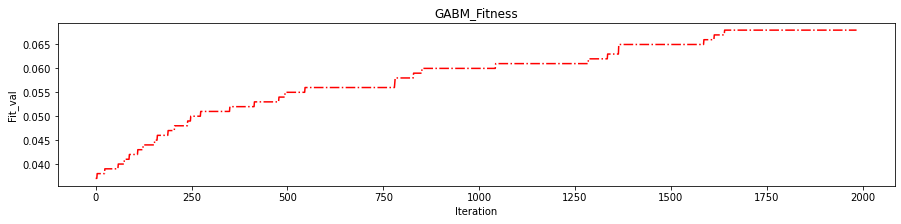

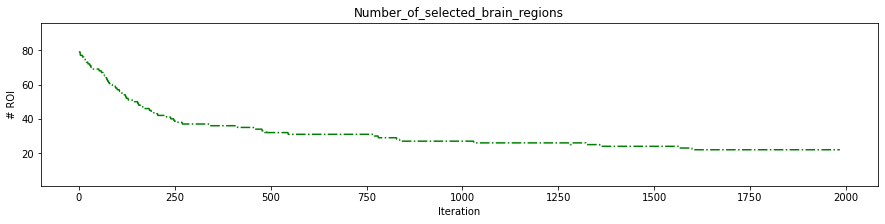

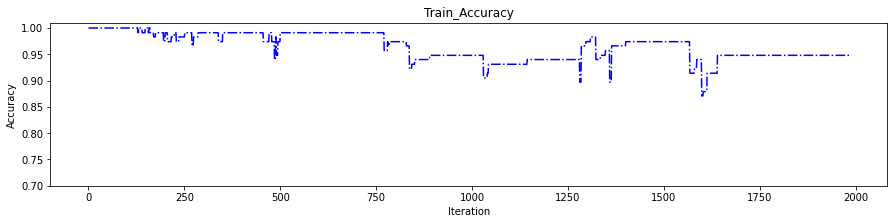

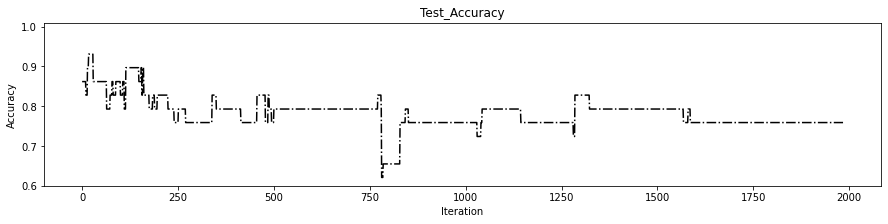

In [8]:
    # all_best_dna=np.load(data_path+'2ALLBestDNA'+'_'+str(alpha), all_best_dna_tmp)
    # np.savetxt(data_path+"2TestGA"+"_"+str(alpha)+".csv", np.vstack((FPI, RPI, API, TAPI)), delimiter=",", fmt='%10.3f')
    # np.save(data_path+'2BestDNA'+'_'+str(alpha), Best_DNA)
alpha = 0.025
import pandas as pd
df=pd.read_csv(data_path+"GA_res/1TestGA"+"_"+str(alpha)+".csv", sep=',',header=None)
_info = df.values[:,:1985]
Best_DNA = np.load(data_path+'GA_res/1BestDNA'+'_'+str(alpha)+'.npy')

tit = ["GABM_Fitness", "Number_of_selected_brain_regions","Train_Accuracy","Test_Accuracy"]
# plt.subplots_adjust(top=3.8)
_fs = (15, 3)

i=0
plt.figure(figsize=_fs)
plt.plot(_info[i,:], 'r-.')
plt.xlabel("Iteration")
plt.ylabel("Fit_val")
plt.title(tit[i])
plt.show()
print(' ')

i=1
plt.figure(figsize=_fs)
plt.plot(_info[i,:], 'g-.')
plt.xlabel("Iteration")
plt.ylabel("# ROI")
plt.ylim(1,96)
plt.title(tit[i])
plt.show()
print(' ')

i=2
plt.figure(figsize=_fs)
plt.plot(_info[i,:], 'b-.')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.ylim(0.7,1.01)
plt.title(tit[i])
plt.show()
print(' ')

i=3
plt.figure(figsize=_fs)
plt.plot(_info[i,:], 'k-.')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.ylim(0.6,1.01)
plt.title(tit[i])
plt.show()



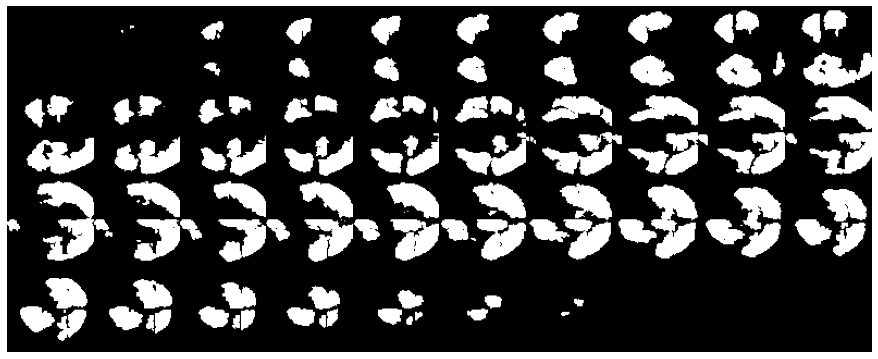

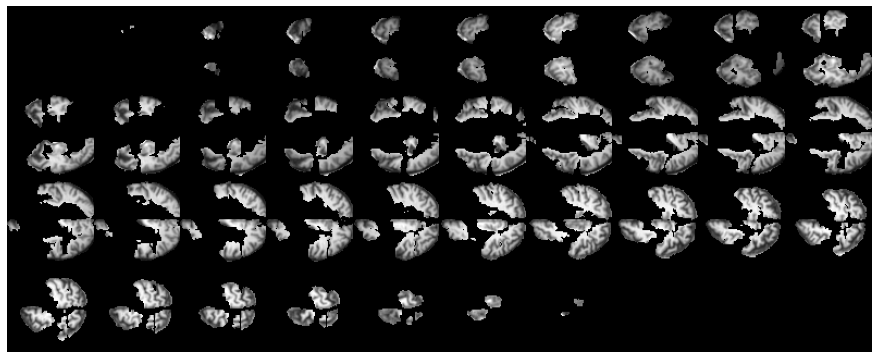

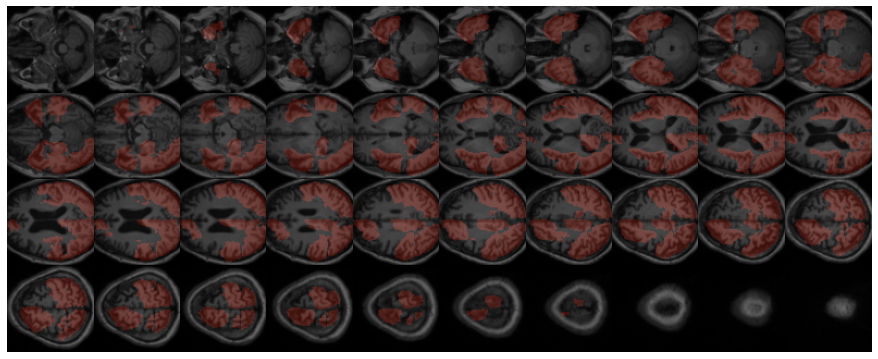

In [9]:
def plot_slices(num_rows, num_columns, width, height, data,cmap="gray"):
    """Plot a montage of 20 MRI slices"""
    data = np.rot90(np.array(data))
    if len(data.shape)==3:
        data = np.transpose(data)
        data = np.reshape(data, (num_rows, num_columns, width, height))
    else:
        data = np.transpose(data,[3,1,0,2])
        data = np.reshape(data, (num_rows, num_columns, width, height, 3))

    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            t_data = data[i][j]     
            axarr[i, j].imshow(t_data, cmap=cmap)
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()




Mask = Chromosome2Mask(Bmasks, Best_DNA, np.zeros((80, 80, 80), dtype=bool))
plot_slices(4, 10, 80, 80, Mask[:, :, ::2])

t_img = x_test[0]
t_img = np.multiply(t_img, Mask)
plot_slices(4, 10, 80, 80, t_img[:, :, ::2])

t_img = x_test[0]
t_res = np.zeros((80,80,3,80),dtype=np.float32)
for i in range(Mask.shape[2]):
    _msk = Mask[:, :, i]*1.0
    _msk = _msk.astype(np.float32)
    _img = t_img[:, :, i]
    _img = (_img-_img.min())/(_img.max()-_img.min())
    c_img = cv2.merge((_img,_img,_img))
    c_msk = cv2.merge((_msk,_msk*0.1,np.zeros_like(_msk)))
    t_res[...,i] = cv2.addWeighted(c_img,0.4,c_msk,0.2,0)

plot_slices(4, 10, 80, 80, t_res[:, :, :, ::2],cmap=None)


In [43]:
All_Best_DNA = np.load(data_path+'GA_res/1ALLBestDNA_0.025.npy')

print(All_Best_DNA.shape)



S1 = All_Best_DNA[1200,:]
S2 = All_Best_DNA[1930,:]

print((S1>0).sum())
print((S2>0).sum())



# for a,b in zip(S1,S2):
#   print(b,'<=>',a)


from scipy import spatial
result = 1 - spatial.distance.cosine(S1, S2)
print(result)


tS = np.random.randint(0,4,96)
result = 1 - spatial.distance.cosine(S1, tS)
print(result)


tS =  np.random.randint(0,4,96)
result = 1 - spatial.distance.cosine(S1, tS)
print(result)

tS = np.ones(96)*3
result = 1 - spatial.distance.cosine(S1, tS)
print(result)

(1990, 96)
26
22
0.8317239361004063
0.4137932497972807
0.3875790678326675
0.48507125007266594
